# Expected Goals (xG) Model Implementation

Expected Goals (xG) is a metric that has been used a lot in football. The metric itself describes the likelihood of whether a shot can result in a goal. To generate the xG value, we need to build a model that can read the conditions of the match and predict the value. 

There are lots of variables that can affect the goal process. Those variables are the distance and angle with the goal post, how many people on the shot region, what playing style occurs in the game, and many more. 

In this notebook, I will show you how to build an xG model using machine learning. In the end, I use gradient boosting as the final model. It includes lots of preprocessing steps ranging from standardizing the numerical variables to encoding the categorical variables.

Now first, we take a look at what the data looks like.

## Open The Data

In [187]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [188]:
import warnings
warnings.filterwarnings('ignore')

In [189]:
with open(root + '/events/7578.json') as f:
    file = json.load(f)

match = pd.json_normalize(file, sep='_')
match.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,substitution_replacement_name,pass_cut_back,foul_committed_type_id,foul_committed_type_name,foul_won_defensive,dribble_nutmeg,shot_aerial_won,pass_goal_assist,foul_committed_card_id,foul_committed_card_name
0,52dd86ff-3645-45d2-b7e5-4352d9c94cf7,1,1,00:00:00.000,0,0,1,0.000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3957a62c-bd93-4d60-b8a0-50fcb4cc86de,2,1,00:00:00.000,0,0,1,0.000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8ced4d0a-8081-4626-8a02-71294523be94,3,1,00:00:00.000,0,0,1,NaN,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ecda0f67-65e3-49a0-91f1-70de83943653,4,1,00:00:00.000,0,0,1,9.975,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,54ac19ea-7c2f-479f-af94-0696b04e870d,5,1,00:00:00.507,0,0,2,1.920,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
shot = match[match.type_name == 'Shot']
shot = shot[['minute', 'duration', 'location', 'play_pattern_name', 'shot_end_location', 'shot_body_part_name', 'shot_technique_name', 'shot_type_name', 'shot_freeze_frame', 'shot_outcome_name']]
shot.head()

,minute,duration,location,play_pattern_name,shot_end_location,shot_body_part_name,shot_technique_name,shot_type_name,shot_freeze_frame,shot_outcome_name
409,7,1.253,"[97.0, 32.0]",Regular Play,"[119.0, 37.0, 0.5]",Right Foot,Normal,Open Play,"[{'location': [95.0, 25.0], 'player': {'id': 5...",Saved
527,11,0.787,"[108.0, 51.0]",From Free Kick,"[118.0, 43.8, 0.9]",Right Foot,Half Volley,Open Play,"[{'location': [98.0, 45.0], 'player': {'id': 5...",Saved
635,13,1.333,"[109.0, 55.0]",From Throw In,"[120.0, 46.0, 2.4]",Right Foot,Normal,Open Play,"[{'location': [109.0, 50.0], 'player': {'id': ...",Off T
934,22,0.573,"[102.0, 23.0]",From Corner,"[111.0, 33.0]",Left Foot,Normal,Open Play,"[{'location': [106.0, 35.0], 'player': {'id': ...",Blocked
939,23,0.240,"[114.0, 48.0]",From Corner,"[114.0, 41.0]",Head,Normal,Open Play,"[{'location': [112.0, 46.0], 'player': {'id': ...",Wayward


## Data Preparation

Machine learning model needs lots of data. Therefore, we need to collect all shots that occurred from all football matches regardless of the competition from the StatsBomb data. Because the data is dirty, which you can see from the example above, I conducted preprocessing steps to clean the data. Also, I generated features from the data for the modeling process. 

The preprocessing steps that I've done were:
- Filter the event data that contain shots,
- Retrieve only shots other than the penalty shootout,
- Convert the Left and Right Foot as one value called as Foot,
- Standardize the data,
- Encode the categorical variables using the LabelEncoder object.

The features that I generated for modelling were:
- The Distance and Angle Between The Shot Position to The Center of Goal Post,
- The Number of Players on The Shot Region ranging from the shot position to the goal post in a triangle format _(I will show you this on the last section)_

The code below shows the helper function that I used.

In [191]:
import math
import numpy as np

# Convert the shot output column to binary values. Goal or No Goal
def mark_goal(x):
    if x == 'Goal':
        return "Goal"
    else:
        return "No Goal"
    

# Convert the body part column to three values. Head, Foot, or Other
def mark_foot(x):
    if x == "Head":
        return "Head"
    elif x == "Other":
        return "Other"
    else:
        return "Foot"
    

# The distance is calculated from the shot position to the center of goal post
def calculate_distance(start, end):
    x1, y1 = start
    x2, y2 = [120, 40]
    
    return (((x2 - x1) ** 2) + ((y2 - y1) ** 2)) ** 0.5
    

# The degree is calculated from the shot position to the edge of goal post
def calculate_angle(start):
    B = start
    A = [120, 36]
    C = [120, 44]
    
    Ax, Ay = A[0] - B[0], A[1] - B[1]
    Cx, Cy = C[0] - B[0], C[1] - B[1]
    
    a = math.atan2(Ay, Ax)
    c = math.atan2(Cy, Cx)
    
    if a < 0:
        a += math.pi * 2
    if c < 0:
        c += math.pi * 2
        
    ang = math.degrees(c - a)
    
    return ang + 360 if ang < 0 else ang

In [192]:
import pandas as pd
from tqdm import tqdm

# The dataframe for collecting shots on each event
shot_completed = pd.DataFrame()

# Gather all event data
for i in tqdm(os.listdir('open-data/data/events')):
    file_path = root + '/events/' + i
    
    with open(file_path) as f:
        file = json.load(f)
    
    match = pd.json_normalize(file, sep="_")
    
    shot = match[match.type_name == 'Shot']
    
    shot = shot[['minute', 'duration', 'location', 'play_pattern_name', 'shot_end_location', 'shot_body_part_name', 'shot_technique_name', 'shot_type_name', 'shot_freeze_frame', 'shot_outcome_name']]
    
    shot = shot[shot.shot_type_name != "Penalty"]
    
    # The Input Variables
    shot['distance'] = shot.apply(lambda x: calculate_distance(x['location'], x['shot_end_location']), axis=1)
    shot['angle'] = shot.apply(lambda x: calculate_angle(x['location']), axis=1)
    shot['x'] = shot.location.apply(lambda x: x[0])
    shot['y'] = shot.location.apply(lambda x: x[1])
    shot['shot_body_part_name'] = shot.shot_body_part_name.apply(lambda x: mark_foot(x))
    
    # The Output Variables
    shot['is_goal'] = shot.shot_outcome_name.apply(lambda x: mark_goal(x))
    
    # Choose the final variables for modeling process
    shot = shot[['minute', 'duration', 'x', 'y', 'distance', 'angle', 'shot_freeze_frame', 'shot_body_part_name', 'play_pattern_name', 'shot_technique_name', 'is_goal']]
    
    shot_completed = pd.concat([shot_completed, shot])

shot_completed = shot_completed.reset_index()
shot_completed = shot_completed.drop(['index'], axis=1)
shot_completed.head()

100%|█████████████████████████████████████████| 941/941 [03:06<00:00,  5.05it/s]


,minute,duration,x,y,distance,angle,shot_freeze_frame,shot_body_part_name,play_pattern_name,shot_technique_name,is_goal
0,4,0.413900,113.5,36.1,7.580237,51.434375,"[{'location': [116.1, 39.4], 'player': {'id': ...",Head,Regular Play,Normal,Goal
1,14,1.057901,108.7,35.5,12.163059,34.417379,"[{'location': [96.8, 48.1], 'player': {'id': 2...",Head,Regular Play,Normal,No Goal
2,16,0.630300,99.2,47.4,22.077137,19.442578,"[{'location': [85.1, 39.7], 'player': {'id': 2...",Foot,From Throw In,Normal,No Goal
3,16,0.150500,112.2,36.4,8.590693,47.191614,"[{'location': [99.7, 51.2], 'player': {'id': 2...",Foot,From Throw In,Normal,No Goal
4,16,0.862075,100.3,47.3,21.009046,20.329278,"[{'location': [116.6, 2.1], 'player': {'id': 2...",Foot,From Corner,Half Volley,No Goal


In [193]:
shot_completed.shape

(23555, 11)

## Exploratory Data Analysis

Before I modeled the data, I conducted the exploratory data analysis to understand each proposed column. The analysis was divided into two parts. The first one is analysis for the numerical variables like angle, distance, minutes played, and duration of a shot. The second part is analysis on categorical variables like the body part, pattern name, and the shot technique<br>

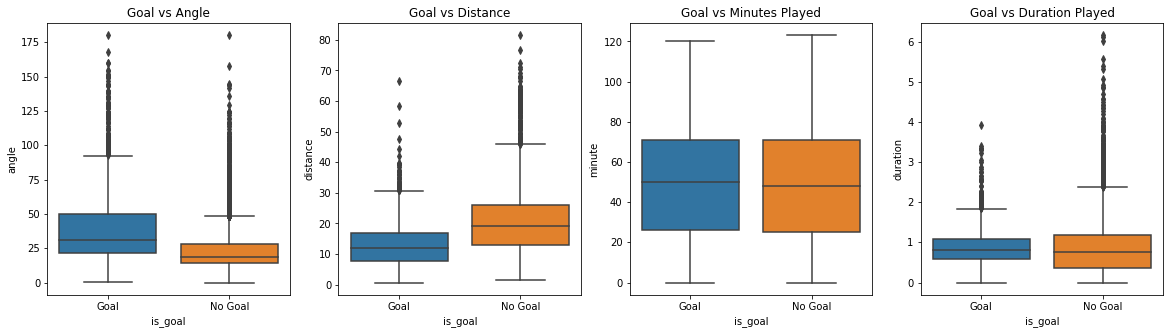

In [194]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sns.boxplot(x="is_goal", y="angle", data=shot_completed, ax=ax[0])
ax[0].set_title('Goal vs Angle')
sns.boxplot(x="is_goal", y="distance", data=shot_completed, ax=ax[1])
ax[1].set_title('Goal vs Distance')
sns.boxplot(x="is_goal", y="minute", data=shot_completed, ax=ax[2])
ax[2].set_title('Goal vs Minutes Played')
sns.boxplot(x="is_goal", y="duration", data=shot_completed, ax=ax[3])
ax[3].set_title('Goal vs Duration Played')

plt.show()

Based on the graph above, shows that each column has a different pattern if the data is grouped based on the goal. The **angle** column shows that as the number of degrees is higher, the higher chances to score a goal. The **distance** column shows that as the distance gets closer, the goal chances get higher.<br> 

Besides both columns, I also added the **minutes played** column and the **duration** column. The reason behind the inclusion of the **minute** column is that I observed so many goals occurred at the end of the second half. As the third chart shows above, there are slightly increased chances to score a goal at the end of the second half. 

The **duration** column is included because I am curious what if that column is added. Because there are higher chances to score a goal if the shot has a short duration to it. As the final chart shows, it seems difficult to look if the column has an impact to generate a goal. Nevertheless, I included the modeling process.

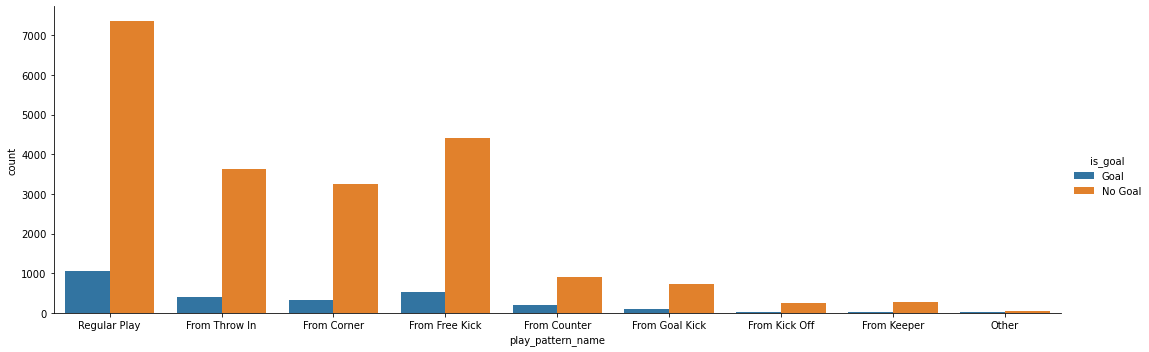

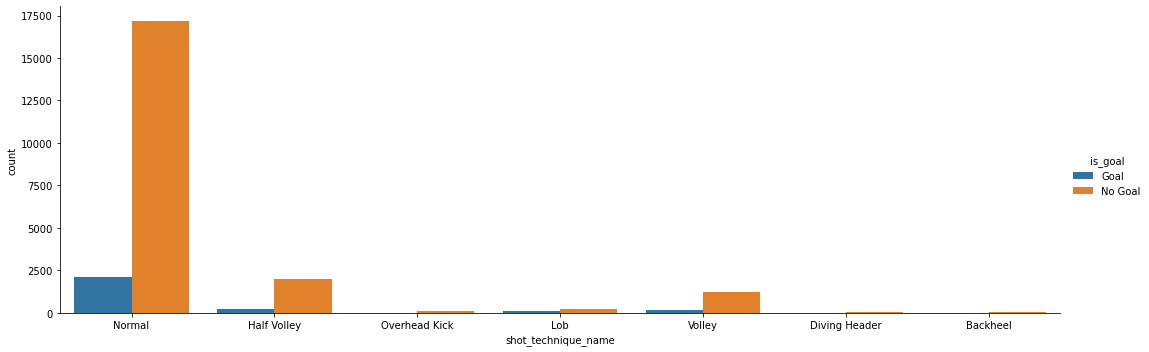

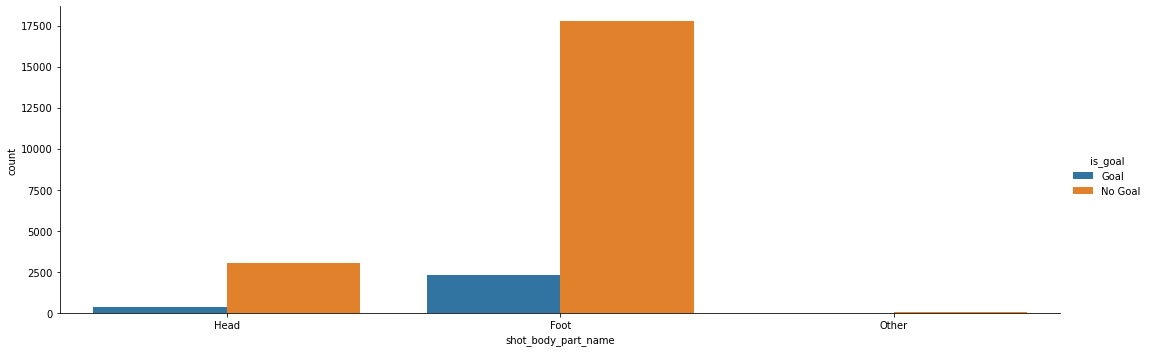

In [195]:
sns.catplot(x="play_pattern_name", kind="count", hue="is_goal", data=shot_completed, height=5, aspect=3)
sns.catplot(x="shot_technique_name", kind="count", hue="is_goal", data=shot_completed, height=5, aspect=3)
sns.catplot(x="shot_body_part_name", kind="count", hue="is_goal", data=shot_completed, height=5, aspect=3)

plt.show()

Based on the graph above, we can see associations between the output variable with the categorical inputs. The play pattern column has a different contribution to the final output.

- From the play pattern name, We can see that goals from the counter have a higher proportion to score goals. 
- From the shot technique name column, we can see that lob has a higher proportion to score goals from it, along with the volley shots. 
- And the body part, we can see the head part has a higher proportion to score a goal.

## Model Implementation

For implementing the xG model, I conducted several experiments. In summary, the modeling processes are divided into several treatments:

- Using features like the coordinates (x, y), distance, angle
- Using previous features along with the duration and minute
    - With those features, I compared models like Logistic Regression and Gradient Boosting. From this, I chose the best model.
- Using previous features along with the categorical variables like the playing pattern, the body part, and shot technique name
- Using previous features and resample the data.

### Features: x, y, distance, angle

In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [197]:
X = shot_completed[['x', 'y', 'distance', 'angle']].values

# Encode the is_goal variable. The 0 value represents No Goal, and the 1 value represents Goal.
y = np.where(shot_completed.is_goal == 'No Goal', 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [198]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4190
           1       0.53      0.03      0.06       521

    accuracy                           0.89      4711
   macro avg       0.71      0.51      0.50      4711
weighted avg       0.85      0.89      0.84      4711



In [199]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      4190
           1       0.48      0.04      0.07       521

    accuracy                           0.89      4711
   macro avg       0.68      0.52      0.51      4711
weighted avg       0.85      0.89      0.84      4711



### Features: x, y, distance, angle, minute, duration

In [200]:
X = shot_completed[['x', 'y', 'distance', 'angle', 'minute', 'duration']].values
y = np.where(shot_completed.is_goal == 'No Goal', 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [201]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4190
           1       0.41      0.03      0.05       521

    accuracy                           0.89      4711
   macro avg       0.65      0.51      0.50      4711
weighted avg       0.84      0.89      0.84      4711



In [202]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      4190
           1       0.52      0.06      0.10       521

    accuracy                           0.89      4711
   macro avg       0.71      0.53      0.52      4711
weighted avg       0.85      0.89      0.85      4711



We can see that by adding more variables, the performance is also increasing, except for logistic regression that has the lowest performance. Therefore, I used the Gradient Boosting Classifier model for further development.

### Features: numerical and categorical variables combined

As you can see from above, the model performance for predicting the goal is still poor. Therefore, I combined the categorical variables as the input. Also, I normalized the numerical variables to diminish dominance from each variable. Therefore, all variables were treated the same.

In [203]:
shot_completed.head()

,minute,duration,x,y,distance,angle,shot_freeze_frame,shot_body_part_name,play_pattern_name,shot_technique_name,is_goal
0,4,0.413900,113.5,36.1,7.580237,51.434375,"[{'location': [116.1, 39.4], 'player': {'id': ...",Head,Regular Play,Normal,Goal
1,14,1.057901,108.7,35.5,12.163059,34.417379,"[{'location': [96.8, 48.1], 'player': {'id': 2...",Head,Regular Play,Normal,No Goal
2,16,0.630300,99.2,47.4,22.077137,19.442578,"[{'location': [85.1, 39.7], 'player': {'id': 2...",Foot,From Throw In,Normal,No Goal
3,16,0.150500,112.2,36.4,8.590693,47.191614,"[{'location': [99.7, 51.2], 'player': {'id': 2...",Foot,From Throw In,Normal,No Goal
4,16,0.862075,100.3,47.3,21.009046,20.329278,"[{'location': [116.6, 2.1], 'player': {'id': 2...",Foot,From Corner,Half Volley,No Goal


In [204]:
X = shot_completed.drop(['is_goal'], axis=1)
y = np.where(shot_completed.is_goal == 'No Goal', 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [205]:
print(X_train.shape)
print(X_test.shape)

(18844, 10)
(4711, 10)


In [206]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

num_var = ['minute', 'duration', 'x', 'y', 'distance', 'angle']

X_train_num = X_train[num_var]
X_test_num = X_test[num_var]

scaler = StandardScaler()
scaler.fit(X_train_num)

X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

In [207]:
cat_var = ['shot_body_part_name', 'play_pattern_name', 'shot_technique_name']

X_train_cat = X_train[cat_var]
X_test_cat = X_test[cat_var]

le = LabelEncoder()

le.fit(X_train_cat.shot_body_part_name)
X_train_cat['shot_body_part_name'] = le.transform(X_train_cat.shot_body_part_name)
X_test_cat['shot_body_part_name'] = le.transform(X_test_cat.shot_body_part_name)

le.fit(X_train_cat.play_pattern_name)
X_train_cat['play_pattern_name'] = le.transform(X_train_cat.play_pattern_name)
X_test_cat['play_pattern_name'] = le.transform(X_test_cat.play_pattern_name)

le.fit(X_train_cat.shot_technique_name)
X_train_cat['shot_technique_name'] = le.transform(X_train_cat.shot_technique_name)
X_test_cat['shot_technique_name'] = le.transform(X_test_cat.shot_technique_name)

X_train_cat = X_train_cat.values
X_test_cat = X_test_cat.values

In [208]:
X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
X_test = np.concatenate([X_test_num, X_test_cat], axis=1)

print(X_train.shape)
print(X_test.shape)

(18844, 9)
(4711, 9)


In [209]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# THE BEST PREVIOUS RESULT 
# (Gradient Boosting with coordinates, minutes of played, 
# and duration of shots variables)
#######################################################
#               precision    recall  f1-score   support

#            0       0.89      0.99      0.94      4190
#            1       0.52      0.06      0.10       521

#     accuracy                           0.89      4711
#    macro avg       0.71      0.53      0.52      4711
# weighted avg       0.85      0.89      0.85      4711

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      4190
           1       0.68      0.15      0.25       521

    accuracy                           0.90      4711
   macro avg       0.79      0.57      0.60      4711
weighted avg       0.88      0.90      0.87      4711



As you can see from above, the model is way more improved than the previous model, especially on the class '1' that represents a goal. But although the model has an accuracy of 90%, the model performs poorly on the class '1'. Therefore, I tried to improve the model by handling the imbalance of the data.

### Handling the imbalance data

Because the data is imbalanced, the model performance for predicting goals is poor. To mitigate this, I resampled the data by using SMOTE. I didn't use undersampling to avoid poor performance and not to use oversampling to avoid overfitting. SMOTE belongs to the oversampling method. But rather than oversample the data explicitly, SMOTE tries to generate new data by interpolating the data based on the data itself.

In [210]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

X = shot_completed.drop(['is_goal'], axis=1)
y = np.where(shot_completed.is_goal == 'No Goal', 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Numerical Variables
num_var = ['minute', 'duration', 'x', 'y', 'distance', 'angle']

X_train_num = X_train[num_var]
X_test_num = X_test[num_var]

scaler = StandardScaler()
scaler.fit(X_train_num)

X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

# Categorical Variables
cat_var = ['shot_body_part_name', 'play_pattern_name', 'shot_technique_name']

X_train_cat = X_train[cat_var]
X_test_cat = X_test[cat_var]

le = LabelEncoder()

le.fit(X_train_cat.shot_body_part_name)
X_train_cat['shot_body_part_name'] = le.transform(X_train_cat.shot_body_part_name)
X_test_cat['shot_body_part_name'] = le.transform(X_test_cat.shot_body_part_name)

le.fit(X_train_cat.play_pattern_name)
X_train_cat['play_pattern_name'] = le.transform(X_train_cat.play_pattern_name)
X_test_cat['play_pattern_name'] = le.transform(X_test_cat.play_pattern_name)

le.fit(X_train_cat.shot_technique_name)
X_train_cat['shot_technique_name'] = le.transform(X_train_cat.shot_technique_name)
X_test_cat['shot_technique_name'] = le.transform(X_test_cat.shot_technique_name)

X_train_cat = X_train_cat.values
X_test_cat = X_test_cat.values

X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
X_test = np.concatenate([X_test_num, X_test_cat], axis=1)

In [211]:
# THE BEST SAMPLING METHOD

from imblearn.over_sampling import SMOTE

# Applying SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      4190
           1       0.31      0.76      0.44       521

    accuracy                           0.78      4711
   macro avg       0.64      0.77      0.65      4711
weighted avg       0.89      0.78      0.82      4711



In [212]:
from imblearn.combine import SMOTEENN

# Applying SMOTE
sm = SMOTEENN(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82      4190
           1       0.26      0.83      0.40       521

    accuracy                           0.72      4711
   macro avg       0.62      0.77      0.61      4711
weighted avg       0.89      0.72      0.77      4711



In [213]:
from imblearn.combine import SMOTETomek

# Applying SMOTE
sm = SMOTETomek(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      4190
           1       0.30      0.75      0.43       521

    accuracy                           0.78      4711
   macro avg       0.63      0.77      0.65      4711
weighted avg       0.89      0.78      0.82      4711



As you can see from the result above, we can see there is a huge improvement in model performance, especially on Precision, Recall, and F1-Score value for the '1' label, where it represents a goal. From all sampling methods that I used, the **SMOTE** method had the best model performance. Therefore, I state this model as the final model.

### Adding New Variables

I am still curious about how to improve the xG model. Therefore, I add another variable. In short, the variable describes the number of players that could block the ball when the shot occurred. To determine whether a player has the potential to block players, I used this formula from GeeksForGeeks (https://www.geeksforgeeks.org/check-whether-a-given-point-lies-inside-a-triangle-or-not/). 

In summary, the formula tries to calculate areas on three different triangles, and each triangle contains the point that we want to predict. If the sum of three triangles is the same as the main triangle, it means that the point lies inside the triangle.

In [214]:
# Calculate triangle
def area(x1, y1, x2, y2, x3, y3):
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2.0)


# Calculate the number of potential players that block the ball within the triangle
# The triangle spans from the shot point to the edge of the goal post
def calculate_blocking_players(x1, y1, frame):
    # The coordinate for each edge of the goal postedge of go
    x2, y2 = [120, 36]
    x3, y3 = [120, 44]

    num_players = 0
    
    for j in frame:

        x, y = j['location']

        A = area(x1, y1, x2, y2, x3, y3)
        A1 = area(x, y, x2, y2, x3, y3)
        A2 = area(x1, y1, x, y, x3, y3)
        A3 = area(x1, y1, x2, y2, x, y)

        count = A == A1 + A2 + A3
        
        num_players = num_players + count
    
    return num_players


shot_completed['blocking_players'] = shot_completed.apply(lambda x: calculate_blocking_players(x['x'], x['y'], x['shot_freeze_frame']), axis=1)
shot_completed.head()

,minute,duration,x,y,distance,angle,shot_freeze_frame,shot_body_part_name,play_pattern_name,shot_technique_name,is_goal,blocking_players
0,4,0.413900,113.5,36.1,7.580237,51.434375,"[{'location': [116.1, 39.4], 'player': {'id': ...",Head,Regular Play,Normal,Goal,0
1,14,1.057901,108.7,35.5,12.163059,34.417379,"[{'location': [96.8, 48.1], 'player': {'id': 2...",Head,Regular Play,Normal,No Goal,0
2,16,0.630300,99.2,47.4,22.077137,19.442578,"[{'location': [85.1, 39.7], 'player': {'id': 2...",Foot,From Throw In,Normal,No Goal,1
3,16,0.150500,112.2,36.4,8.590693,47.191614,"[{'location': [99.7, 51.2], 'player': {'id': 2...",Foot,From Throw In,Normal,No Goal,0
4,16,0.862075,100.3,47.3,21.009046,20.329278,"[{'location': [116.6, 2.1], 'player': {'id': 2...",Foot,From Corner,Half Volley,No Goal,0


<AxesSubplot:xlabel='is_goal', ylabel='blocking_players'>

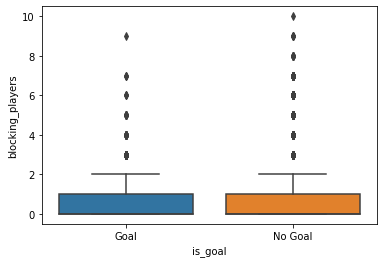

In [215]:
sns.boxplot(x="is_goal", y="blocking_players", data=shot_completed)

In [216]:
shot_completed.blocking_players.value_counts()

0     12452
1      7019
2      2457
3       882
4       421
5       184
6        89
7        35
8         9
9         6
10        1
Name: blocking_players, dtype: int64

Although the boxplot shows there are no correlations between the occurrence of goals with the number of blocking players, we can see there are some patterns at the outlier points that the shot can become a goal if there are fewer people that could block the shot. Now let's see if the model improves when we use this feature.

In [217]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Gather all the input variables
X = shot_completed.drop(['is_goal'], axis=1)

# Encode the is_goal variable. The 0 value represents No Goal, and the 1 value represents Goal.
y = np.where(shot_completed.is_goal == 'No Goal', 0, 1)

# Divide the data into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Numerical Variables
num_var = ['minute', 'duration', 'x', 'y', 'distance', 'angle', 'blocking_players']

# Scaling the numerical variables to avoid any dominance
X_train_num = X_train[num_var]
X_test_num = X_test[num_var]

# I fit only the train data to avoid any data leakage from the test data
scaler = StandardScaler()
scaler.fit(X_train_num)

X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

# Categorical Variables
cat_var = ['shot_body_part_name', 'play_pattern_name', 'shot_technique_name']

X_train_cat = X_train[cat_var]
X_test_cat = X_test[cat_var]

le = LabelEncoder()

le.fit(X_train_cat.shot_body_part_name)
X_train_cat['shot_body_part_name'] = le.transform(X_train_cat.shot_body_part_name)
X_test_cat['shot_body_part_name'] = le.transform(X_test_cat.shot_body_part_name)

le.fit(X_train_cat.play_pattern_name)
X_train_cat['play_pattern_name'] = le.transform(X_train_cat.play_pattern_name)
X_test_cat['play_pattern_name'] = le.transform(X_test_cat.play_pattern_name)

le.fit(X_train_cat.shot_technique_name)
X_train_cat['shot_technique_name'] = le.transform(X_train_cat.shot_technique_name)
X_test_cat['shot_technique_name'] = le.transform(X_test_cat.shot_technique_name)

X_train_cat = X_train_cat.values
X_test_cat = X_test_cat.values

X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
X_test = np.concatenate([X_test_num, X_test_cat], axis=1)

In [218]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

#######################################################
# PREVIOUS RESULT (Gradient Boosting with SMOTE sampling method)
#######################################################
#               precision    recall  f1-score   support

#            0       0.96      0.79      0.87      4190
#            1       0.31      0.76      0.44       521

#     accuracy                           0.78      4711
#    macro avg       0.64      0.77      0.65      4711
# weighted avg       0.89      0.78      0.82      4711

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      4190
           1       0.33      0.75      0.46       521

    accuracy                           0.80      4711
   macro avg       0.64      0.78      0.67      4711
weighted avg       0.89      0.80      0.83      4711



**The model improves!** By adding that variable, I managed to get 0.02 percent of improvement on precision and f1-score. Keep in mind that a small percentage of improvement still matters. From this, I have finished improving the model. Besides the modeling process, I also look at which variables have a contribution to the prediction result.

## The Variable Importance

In [229]:
feature_names = ['minute', 'duration', 'x', 'y', 'distance', 'angle', 'blocking_players', 'shot_body_part_name', 'play_pattern_name', 'shot_technique_name']
feature_importance = model.feature_importances_

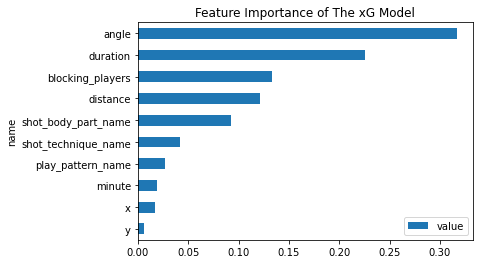

In [251]:
fi = pd.DataFrame()
fi['name'] = feature_names
fi['value'] = feature_importance
fi.sort_values('value').plot('name', 'value', kind='barh')

plt.title('Feature Importance of The xG Model')
plt.show()

The graph above describes the importance of each variable on the prediction result. You can see that the angle variable is the most important variable of all variables. Then, it follows by duration, blocking_players, distance, body part, technique, play pattern, minute, and coordinates based on its importance, respectively. 

Surprisingly, my proposed variable, the blocking players, becomes the second most important variable. From this result, I am certain that the goal shot is determined by the number of people that could block the shot. 